## Análise Estatística Descritiva e Inferencial da Sincronização de Tempo em Redes Locais Usando LinuxPTP

A sincronização precisa de tempo em redes de computadores é fundamental para diversas aplicações, incluindo redes industriais, telecomunicações e data centers. Neste trabalho, utilizamos o [LinuxPTP](https://linuxptp.sourceforge.net/), uma implementação do [**Precision Time Protocol (PTP)**](https://endruntechnologies.com/pdf/PTP-1588.pdf), para simular e analisar a sincronização de tempo entre diferentes nós de uma rede. O LinuxPTP oferece uma maneira robusta de sincronizar relógios em diferentes dispositivos numa LAN, permitindo atingir precisões na ordem de microssegundos ou até nanosegundos, dependendo das condições da rede e do hardware disponível.

A análise deste trabalho é feita utilizando **Estatística Descritiva e Inferencial**, com a aplicação de **testes de hipóteses** para avaliar o comportamento da sincronização em diferentes cenários. Para isso, configuramos nós em uma rede local que atuam como mestres e escravos PTP, e coletamos dados de _**Time offset**_ durante a sincronização.

Os principais objetivos deste trabalho incluem:

- **Testar Timestamping em Software vs. Hardware**: Comparar a eficácia da sincronização utilizando **timestamping em software** e **timestamping em hardware**.

- **Avaliar a Qualidade da Sincronização**: Examinar se o **offset** entre o mestre e o escravo se mantém próximo de zero em diferentes condições de rede.

- **Comparar Topologias de Sincronização**: Verificar a eficácia de diferentes configurações, como topologias **mestre-escravo** simples e aquelas que envolvem **_Transparent Clocks_** ou **_Boundary Clocks_**.



## Ambiente de testes

Para este estudo, utilizamos 3 computadores cuja as especificações são descritas na tabela abaixo:

| Especificação      | PC 1 (jv3301)                | PC 2 (Vostro-3470)               | PC 3 (lasse100)                      |
|--------------------|---------------------------------|--------------------------------------------|-----------------------------------------|
| OS                 | Ubuntu 22.04.5 LTS x86_64       | Ubuntu 22.04.4 LTS x86_64                  | Ubuntu 18.04.4 LTS x86_64               |
| Kernel             | 6.8.0-45-generic                | 6.5.0-35-generic                           | 4.15.0-213-generic                      |
| NIC                 | Intel X550-T2 PCI-E X4         | Intel X550-T2 PCI-E X4                     | Intel X550-T2 PCI-E X4      |
| CPU                | Intel i5-7600 (4) @ 4.10GHz     | Intel i5-9400 (6) @ 4.10GHz                | Intel i7-5930K (12) @ 3.700GHz          |
| GPU                | Intel HD Graphics 630           | Intel HD Graphics 630  | AMD Radeon HD 7770/8760                 |
| Memory             | 8GB                 | 16GB                           | 64GB                        |



Os dados são coletados diretamente dos logs do **ptp4l**, a ferramenta do LinuxPTP que executa a sincronização. 


## Linux PTP

O [LinuxPTP](https://linuxptp.sourceforge.net/) é uma implementação do Precision Time Protocol (PTP), conforme definido pelo padrão [**IEEE 1588**](https://endruntechnologies.com/pdf/PTP-1588.pdf). O PTP é um protocolo de rede utilizado para sincronizar relógios em sistemas de computadores distribuídos através de uma rede local (LAN).

Componentes Principais:

- ptp4l: O daemon principal do LinuxPTP, responsável por implementar o protocolo PTP e gerenciar a sincronização de tempo entre os dispositivos.
- phc2sys: Uma ferramenta auxiliar que sincroniza o relógio de hardware do PTP (PHC) com o relógio do sistema, garantindo que ambos permaneçam alinhados.

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/jvictorferreira3301/LPTP_Analyzer/refs/heads/main/assets/HS.png" width="840" height="480" allow="autoplay"></iframe>
</div>

## $I$. Software Timestamping Vs. Hardware Timestamping

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/jvictorferreira3301/LPTP_Analyzer/refs/heads/main/assets/ptp-hardware-software-based-timestamp.png" width="640" height="480" allow="autoplay"></iframe>
</div>

Abaixo, realizamos o carregamento e processamento dos logs de PTP para extrair informações de time offset e frequency offset, a fim de armazenar esses dados em DataFrames para posterior análise e visualização.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from log_processing import process_log_file
from plotting import plot_graphs
import numpy as np
from scipy.stats import ttest_ind

# Padroes de time e freq
offset_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)'
freq_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)'

log_files = ['logs/Soft.txt', 'logs/Hard.txt']

dataframes = {}

for log_file in log_files:
    dataframes[log_file] = process_log_file(log_file, offset_pattern, freq_pattern)

### Dados do sincronismo usando software timestamping

In [2]:
df_s_log = dataframes['logs/Soft.txt']
df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,312.000000,312.000000,291.000000,312.000000
mean,14419.287776,-395.070513,-9318.202749,155.981776
std,90.652489,73829.599313,2086.863093,90.652489
min,14263.306000,-395149.000000,-23638.000000,0.000000
25%,14341.065000,3997.250000,-9487.500000,77.759000
50%,14418.823000,9868.000000,-9189.000000,155.517000
75%,14497.581250,20932.250000,-8827.000000,234.275250
max,14575.340000,171637.000000,-917.000000,312.034000


In [6]:
# Selecionar o DataFrame
df_s_log = dataframes['logs/Soft.txt']

df_s_log = df_s_log[(df_s_log['offset'] >= -80000) & (df_s_log['offset'] <= 80000)]

dataframes['logs/Soft.txt'] = df_s_log

df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,284.000000,284.000000,284.000000,284.000000
mean,14431.729292,13058.426056,-9327.161972,168.423292
std,83.441123,19716.930080,1654.016549,83.441123
min,14280.308000,-75648.000000,-20740.000000,17.002000
25%,14360.067000,4692.500000,-9485.750000,96.761000
50%,14431.824000,10241.000000,-9194.500000,168.518000
75%,14504.582000,20623.500000,-8833.500000,241.276000
max,14575.340000,76842.000000,-5619.000000,312.034000


### Dados do sincronismo usando hardware timestamping

In [19]:
df_h_log = dataframes['logs/Hard.txt']
df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,313.000000,313.000000,147.000000,313.000000
mean,1149.014217,-398.865815,-4.088435,156.014217
std,90.508826,4982.937770,4.453604,90.508826
min,993.000000,-62438.000000,-16.000000,0.000000
25%,1071.006000,-3.000000,-8.000000,78.006000
50%,1149.014000,-1.000000,-2.000000,156.014000
75%,1227.022000,4.000000,-1.000000,234.022000
max,1305.031000,21.000000,0.000000,312.031000


In [8]:
# Selecionar o DataFrame
df_h_log = dataframes['logs/Hard.txt']

# Remover os primeiros 2 registros
df_h_log = df_h_log.iloc[2:]
dataframes['logs/Hard.txt'] = df_h_log

df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,311.000000,311.000000,147.000000,311.000000
mean,1150.014309,0.090032,-4.088435,157.014309
std,89.931436,8.032892,4.453604,89.931436
min,995.000000,-18.000000,-16.000000,2.000000
25%,1072.506000,-3.000000,-8.000000,79.506000
50%,1150.014000,-1.000000,-2.000000,157.014000
75%,1227.522000,4.000000,-1.000000,234.522000
max,1305.031000,21.000000,0.000000,312.031000


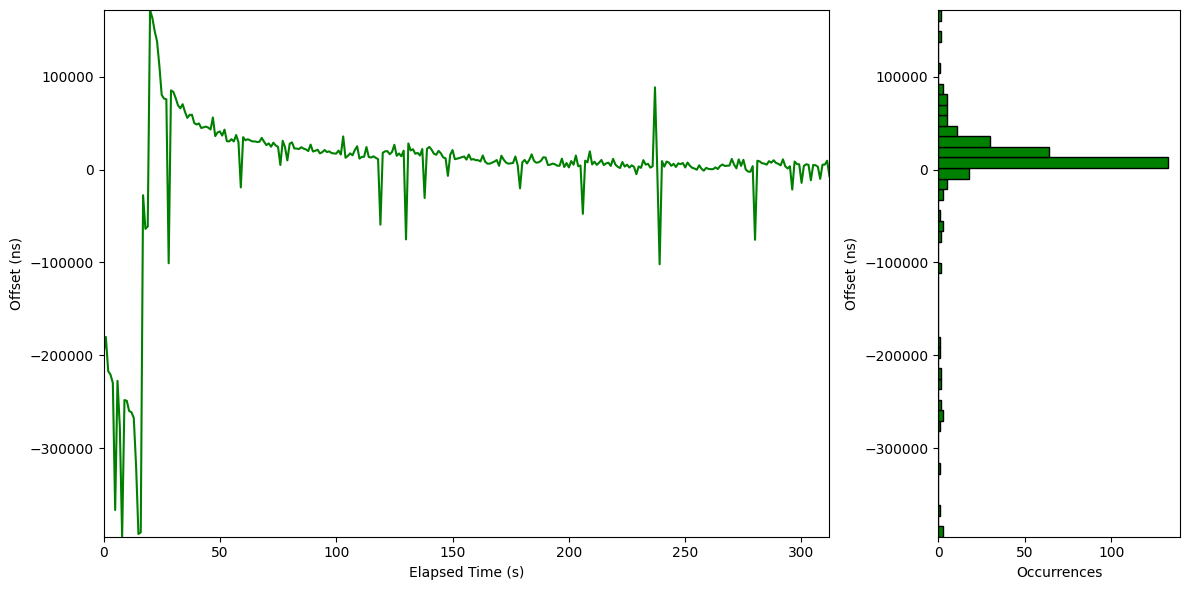

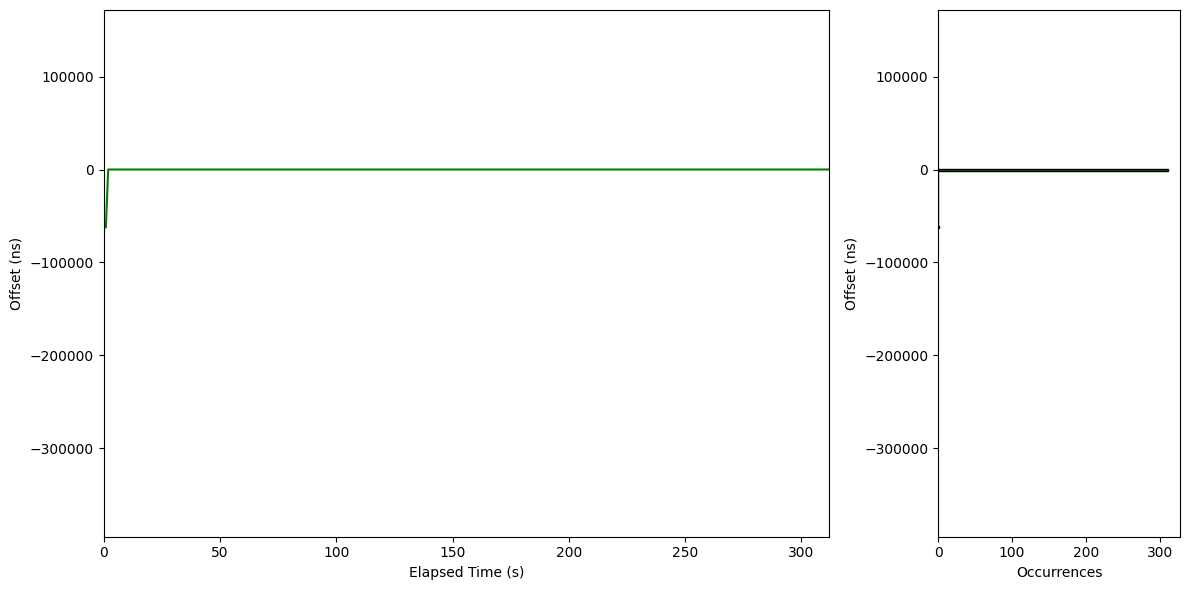

In [20]:
plot_graphs(log_files, dataframes, 'Offset (ns)', 'offset_results', 'green')

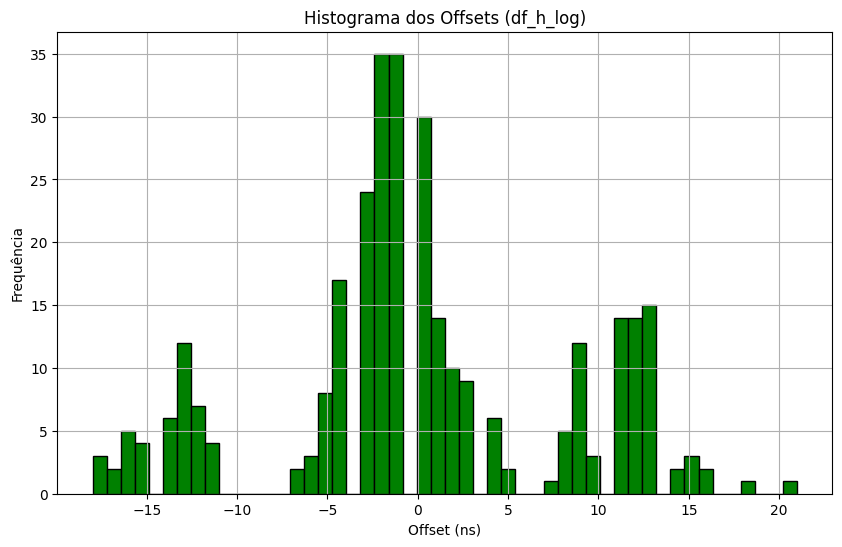

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df_h_log['offset'], bins=50, edgecolor='black', color='green')
plt.title('Histograma dos Offsets (df_h_log)')
plt.xlabel('Offset (ns)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [14]:
# Extrair as colunas de interesse
offsets_hardware = df_h_log['offset']
offsets_software = df_s_log['offset']

# Executar o teste t de Student
t_stat, p_value = ttest_ind(offsets_hardware, offsets_software, equal_var=False)

# Exibir os resultados
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretar o resultado
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")

T-statistic: -11.161117511190199
P-value: 3.263967118628139e-24
Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.
